# COMP-767 : Reinforcement Learning - Assigment 1

## Bandits algorithm
I choosed option (a) that is based on the paper Best-arm identification algorithms for multi-armed bandits in the fixed confidence setting,
Kevin Jamieson and Robert Nowak, CISS, 2014
https://people.eecs.berkeley.edu/˜kjamieson/resources/bestArmSurvey.pdf

(a) Summarize the main results in the paper

(b) Reproduce the results in Figure 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
class BanditMachine(object):
    def __init__(self, k):
        self.k = k
        self.q_star = np.random.normal(0,1,k)
        self.q_star_variance = 1.0

    def pull_arm(self, arm):
        assert 0 <= arm < self.k
        return np.random.normal(self.q_star[arm], self.q_star_variance)

    def optimal_action(self):
        return np.argmax(self.q_star)

In [15]:
class AlgorithmBandit:
    def __init__(self, k, initial_value=0):
        self.k = k
        self.N = np.zeros(k)
        self.Q = np.zeros(k) + initial_value
        self.t = 0
        self.rewards=[]
        self.actions=[]
        self.regrets=[]

    def policy(self):
        pass
    
    def update_N_Q(self, A, R):
        self.N[A] += 1
        self.Q[A] += (R - self.Q[A]) / self.N[A]
        
    def record(self, bandit_machine, A, R):
        self.actions.append(A)
        self.rewards.append(R)
        self.regrets.append(bandit_machine.q_star[bandit_machine.optimal_action()] - R)

    def take_action(self, bandit_machine):
        set_A = self.policy()
        for A in set_A:
            self.t += 1
            R = bandit_machine.pull_arm(A)
            self.update_N_Q(A, R)
            
            self.record(bandit_machine, A, R)

In [ ]:
n = 6
bandit_machine_paper = BanditMachine(n)
bandit_machine_paper.q_star = np.array([1, 4/5, 3/5, 2/5, 1/5, 0])
bandit_machine_paper.q_star_variance = 0.25

In [30]:
def U(t, d=0.1, epsilon=0.01):
    m = (1+epsilon) * t
    return (1+ np.sqrt(epsilon)) * np.sqrt(m*np.log(np.log(m)/d) /(2*t))

class ActionEliminate(AlgorithmBandit):
    def __init__(self, k, initial_value=0):
        super().__init__(k, initial_value)
        
    def C(self, t_i):
        return 2*U(t_i, 0.1/self.k)

    def policy(self):
        #first step
        if np.where(self.N == 0)[0].any():
            return [i for i in range(self.k)]
        
        #step > 1
        a = np.argmax(self.Q)
        bounds = [self.C(self.N[i]) for i in range(self.k)]
        
        set_A=[a]
        for i in range(self.k):
            if i != a:
                if self.Q[a] - bounds[a] < self.Q[i] + bounds[i]:
                    set_A.append(i)
        return set_A

nb_test = 200
nb_pulls = 200
actions=[]
for test in range(nb_test):
    ae = ActionEliminate(n)
    for pull in range(nb_pulls):
        ae.take_action(bandit_machine_paper)  
    actions.append(ae.actions)

C:\Users\Jean-Gabriel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
min_l = min([len(a) for a in actions])
prop=np.zeros((min_l, n))
for i in range(n):
    for j in range(min_l-n):
        for k in range(nb_test):
            if actions[k][j] == i:
                prop[j,i] += 1

                prop2= np.zeros((min_l-n, n))
for i in range(min_l-n):
    prop2[i,:]=np.sum(prop[i:i+n,:],axis=0)
    prop2[i,:] /= prop2[i,:].sum()

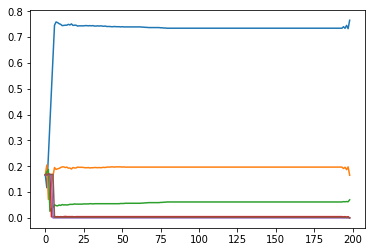

In [32]:
for i in range(n):
    plt.plot(prop2[:,i])

In [35]:
prop2[:10,:].round(2)

array([[0.17, 0.17, 0.17, 0.17, 0.17, 0.17],
       [0.12, 0.2 , 0.18, 0.17, 0.17, 0.17],
       [0.24, 0.07, 0.19, 0.17, 0.17, 0.17],
       [0.37, 0.1 , 0.03, 0.17, 0.17, 0.17],
       [0.49, 0.13, 0.04, 0.  , 0.17, 0.17],
       [0.62, 0.16, 0.04, 0.  , 0.  , 0.17],
       [0.75, 0.2 , 0.05, 0.01, 0.  , 0.  ],
       [0.76, 0.19, 0.05, 0.  , 0.  , 0.  ],
       [0.76, 0.19, 0.05, 0.  , 0.  , 0.  ],
       [0.75, 0.19, 0.05, 0.  , 0.  , 0.  ]])

In [ ]:
def alpha(beta, d):
    m=((2+beta)/beta)**2
    return m * (1 + np.log(2*np.log(m*n/d))/np.log(n/d))
    
def UCB_C(beta, t_i, d, n):
    return (1+beta) * U(t_i, d/n)

In [ ]:
class UpperConfidenceBound(AlgorithmBandit):
    def __init__(self, k, epsilon=0, initial_value=0):
        super().__init__(k, initial_value)
        self.epsilon = epsilon

    def policy(self):
        if np.random.rand() < 1 - self.epsilon:
            return [np.argmax(self.Q)]
        else:
            return [np.random.randint(0, self.k)]

In [ ]:
class LowerUpperConfidenceBound(AlgorithmBandit):
    def __init__(self, k, epsilon=0, initial_value=0):
        super().__init__(k, initial_value)
        self.epsilon = epsilon

    def policy(self):
        if np.random.rand() < 1 - self.epsilon:
            return [np.argmax(self.Q)]
        else:
            return [np.random.randint(0, self.k)]

(c) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). Do not forget to average your results over multiple independent runs.

In [5]:
class EpsilonGreedy(AlgorithmBandit):
    def __init__(self, k, epsilon=0, initial_value=0):
        super().__init__(k, initial_value)
        self.epsilon = epsilon

    def policy(self):
        if np.random.rand() < 1 - self.epsilon:
            return [np.argmax(self.Q)]
        else:
            return [np.random.randint(0, self.k)]

In [6]:
class OptimisticGreedy(EpsilonGreedy):
    def __init__(self, k, initial_value=0):
        super().__init__(k, epsilon=0, initial_value=initial_value)

In [7]:
class UpperConfidenceBound1(AlgorithmBandit):
    def __init__(self, k, c=1, initial_value=0):
        super().__init__(k, initial_value)
        self.c = c  # degree of exploration

    def policy(self):
        never_tried = np.where(self.N == 0)[0]
        if never_tried.any():
            return [never_tried[0]]
        return [np.argmax(self.Q + self.c * np.sqrt(np.log(self.t) / self.N))]

In [10]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class GradientAscent(AlgorithmBandit):
    def __init__(self, k, step_size=0.125, initial_value=0):
        super().__init__(k, initial_value)
        self.H = np.zeros(k)  # preference of each action
        self.step_size = step_size  # learning rate
        self.base_line = 0  # choose baseline = average of all reward
      
    def take_action(self, bandit_machine):
        self.t += 1
        policy = softmax(self.H)
        A = np.random.choice(self.k, p=policy)
        R = bandit_machine.pull_arm(A)

        for i in range(self.k):
            if i == A:
                self.H[i] += self.step_size * (R - self.base_line) * (1 - policy[i])
            else:
                self.H[i] -= self.step_size * (R - self.base_line) * policy[i]

        self.base_line += (R - self.base_line) / self.t
        
        self.record(bandit_machine, A, R)

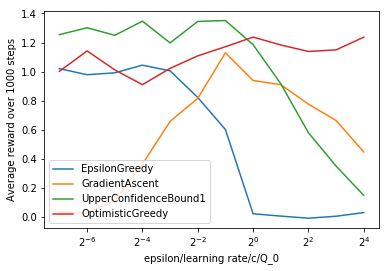

In [11]:
def parameter_study(param, type_algo, k=10, nb_test=100, nb_step = 100):
    rewards = np.zeros((len(param), nb_test, nb_step))
    for i in range(len(param)):
        for j in range(nb_test):
            algo = type_algo(k, param[i])
            bandit = BanditMachine(k)
            for n in range(nb_step):
                algo.take_action(bandit)
            rewards[i,j,:] = algo.rewards

    return np.mean(np.mean(rewards, axis=1), axis=1)


nb_test = 100
nb_step = 100
k=10

param = [2**i for i in range(-7, 5, 1)]
algos = [EpsilonGreedy, 
         GradientAscent, 
         UpperConfidenceBound1,
         OptimisticGreedy]

parameter_study_values={}
for algo in algos:
    parameter_study_values[algo.__name__] = parameter_study(param, algo, k, nb_test, nb_step)
    
####### PLOT

for algo_name in parameter_study_values:
    plt.plot(param, parameter_study_values[algo_name], label=algo_name)
plt.xscale("log", basex=2)
plt.xlabel("epsilon/learning rate/c/Q_0")
plt.ylabel("Average reward over 1000 steps")
plt.legend()
plt.show()

(d) Discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identification

# Markov Decision Processes and dynamic programming
I choosed option (a)

In [ ]:
n = 6
b = bandits.Bandits(n)
b.q_star = np.array([1, 4/5, 3/5, 2/5, 1/5, 0])
b.q_star_variance = 0.25

In [ ]:
n_trials = 20
n_pulls = 30
pulls = np.zeros((n_pulls, n))

for i in range(n_trials):
    UCB = bandits.UpperConfidenceBound(k=n, c=0.1)
    for j in range(n_pulls):
        choix = UCB.policy()
        pulls[j,choix] += 1
        UCB.take_action(b)


In [ ]:
n_trials = 20
n_pulls = 30
h = np.zeros((n_trials, n_pulls, n))
l = np.zeros((n_trials, n_pulls, n))

for i in range(n_trials):
    LUCB = bandits.LowerUpperConfidenceBound(k=n, c=0.1)
    for j in range(n_pulls):
        h_j, l_j = LUCB.take_action(b)
        h[i, j, h_j] = 1
        l[i, j, l_j] = 1

    prop = np.zeros((n_pulls - n, n))
    for k in range(n_pulls - n):
        prop[k,:] = np.sum(h[i, k:k+n-1,:], axis=0 ) + np.sum(l[i, k:k+n-1,:], axis=0 )


